In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("COVID19_line_list_data.csv")
df = df.dropna(subset=["age", "death"])
df.head()

,id,case_in_country,reporting date,Unnamed: 3,summary,location,country,gender,age,symptom_onset,...,recovered,symptom,source,link,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,1,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,"Shenzhen, Guangdong",China,male,66.0,01/03/20,...,0,NaN,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,Shanghai,China,female,56.0,1/15/2020,...,0,NaN,Official Weibo of Shanghai Municipal Health Co...,https://www.weibo.com/2372649470/IqogQhgfa?fro...,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,1/21/2020,NaN,First confirmed imported cases in Zhejiang: pa...,Zhejiang,China,male,46.0,01/04/20,...,0,NaN,Health Commission of Zhejiang Province,http://www.zjwjw.gov.cn/art/2020/1/21/art_1202...,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,1/21/2020,NaN,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,female,60.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,1/21/2020,NaN,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,male,58.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
def convertDates(s):
    if s != "0" and s != "1":
        return 1
    return int(s)

#Extract Age and Death columns
#Convert death column into 1s and 0s.
ages = df["age"]
deaths = df["death"].apply(convertDates)

ages.value_counts(bins=5), deaths.value_counts()


((38.55, 57.7]    296
 (57.7, 76.85]    237
 (19.4, 38.55]    231
 (76.85, 96.0]     47
 (0.153, 19.4]     32
 Name: age, dtype: int64,
 0    785
 1     58
 Name: death, dtype: int64)

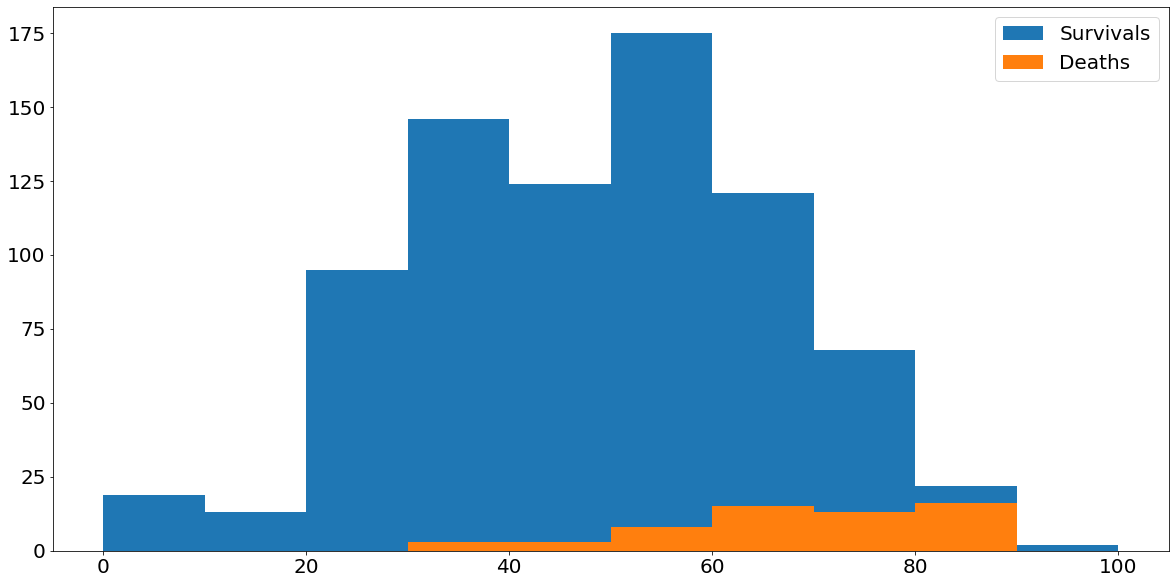

In [184]:
#Do logistic regression on probability of survival as a function of age
from sklearn.linear_model import LogisticRegression as LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Get the probability of death first
x = np.array(ages)
y = np.array(deaths)

p = len(deaths[deaths == 1]) / len(deaths)
bins = np.linspace(0, 100, 11)
freqnegatives = plt.hist(x[y == 0], bins = bins, label="Survivals")
freqpositives = plt.hist(x[y == 1], bins = bins, label="Deaths")

#Get the bin centers. 
#So we can use them later.
binCenters = (bins[1:] + bins[:-1]) / 2
binCenters, bins


#Make it pretty
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig = plt.gcf()
fig.set_size_inches(20,10)

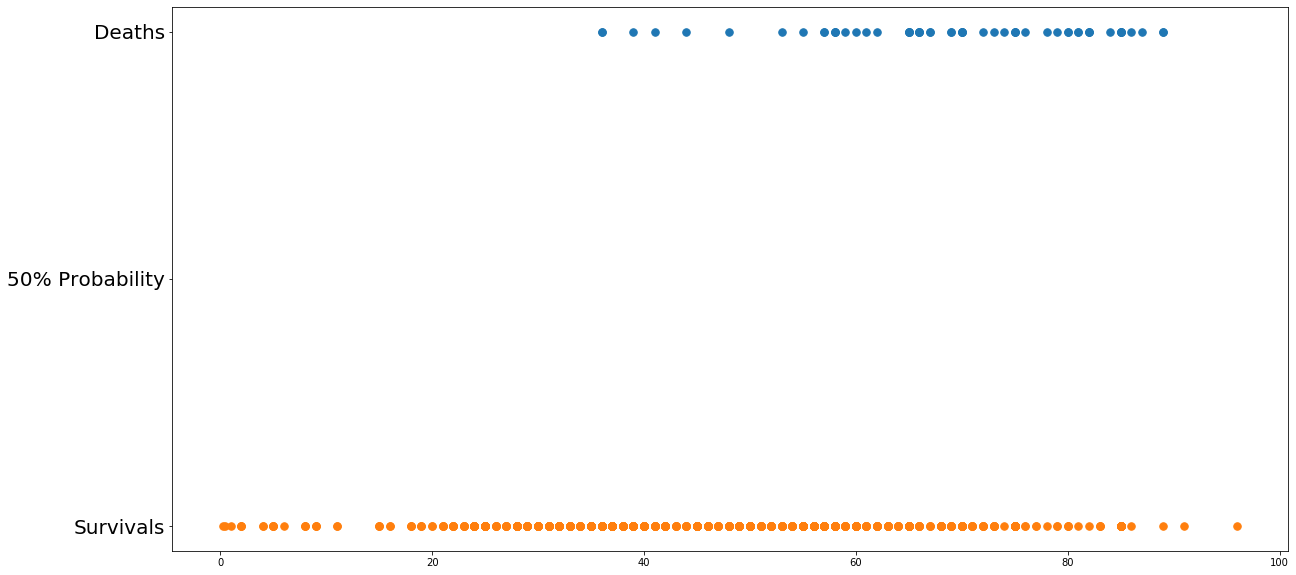

In [185]:
#Make a scatter plot of the deaths and survivals.
positives = x[y == 1]
negatives = x[y == 0]
plt.plot(positives, [1] * len(positives), linestyle="none", marker=".", markersize=15)
plt.plot(negatives, [0] * len(negatives), linestyle="none", marker=".", markersize=15)
plt.yticks([0, 0.5, 1], ["Survivals", "50% Probability", "Deaths"], fontsize=20)
fig = plt.gcf()
fig.set_size_inches(20,10)

In [186]:
# Get a single prediction curve, from a single train/test split
def logistic(x, a, b):
    return 1 / (1 + np.exp(-a - x * b))
xtrain, xtest, ytrain, ytest = train_test_split(x.reshape(-1,1), y)
model = LogisticRegression()
model.fit(xtrain, ytrain)
a = model.intercept_[0]
b = model.coef_[0]
xspace = np.linspace(min(x), max(x), 100)
ycurve = logistic(xspace, a, b)


In [187]:
# Run 1000 train/test splits and average the accuracies.
# Get the accuracies, a parameters, and b parameters in lists.
# Show the averages of these metrics.
def tts_repeat(numRepeats, x, y):
    accs = []
    aparams = []
    bparams = []
    xtests = []
    ytests = []
    for i in range(numRepeats):
        xtrain, xtest, ytrain, ytest = train_test_split(x.reshape(-1,1),y)
        model = LogisticRegression()
        model.fit(xtrain, ytrain)
        ypredict = model.predict(xtest)
        accs.append(accuracy_score(ytest, ypredict))
        aparams.append(model.intercept_[0])
        bparams.append(model.coef_[0][0])
        xtests.append(xtest)
        ytests.append(ytest)
    return accs, aparams, bparams, xtest, ytest

accs, aparams, bparams, xtests, ytests = tts_repeat(1000, x, y)
np.mean(accs), np.std(accs), np.mean(aparams), np.mean(bparams)

(0.9297914691943127,
 0.015037522604944039,
 -7.336057506130665,
 0.07984587610864996)

((array([  2.,   9.,  22.,  41.,  95., 207., 256., 235., 108.,  25.]),
  array([-9.1510659 , -8.86614689, -8.58122788, -8.29630888, -8.01138987,
         -7.72647086, -7.44155185, -7.15663285, -6.87171384, -6.58679483,
         -6.30187582]),
  <a list of 10 Patch objects>),
 (array([ 82., 452., 385.,  68.,  13.]),
  array([0.06247672, 0.07119786, 0.07991901, 0.08864015, 0.09736129,
         0.10608244]),
  <a list of 5 Patch objects>),
 (array([  5.,  12.,  54., 119., 222., 249., 184., 108.,  39.,   8.]),
  array([0.88151659, 0.89052133, 0.89952607, 0.90853081, 0.91753555,
         0.92654028, 0.93554502, 0.94454976, 0.9535545 , 0.96255924,
         0.97156398]),
  <a list of 10 Patch objects>))

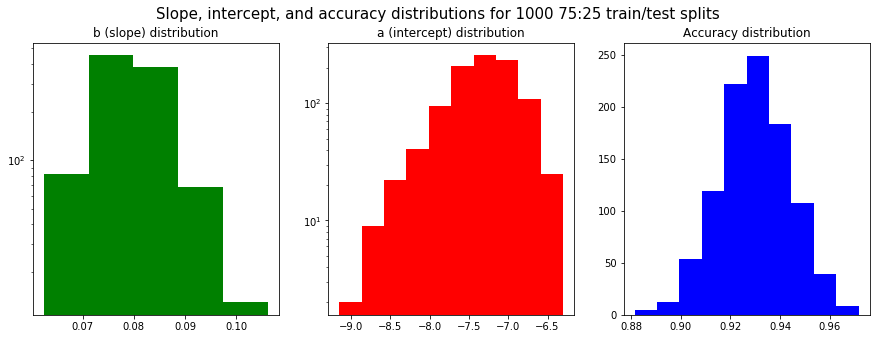

In [188]:
#Plot distributions for the parameters from our train/test splits
fig, axs = plt.subplots(1,3)
bhist = axs[0].hist(bparams, bins=5, color="green")
axs[0].set_title(label="b (slope) distribution")
axs[0].set_yscale("log")
ahist  = axs[1].hist(aparams, color="red")
axs[1].set_title(label="a (intercept) distribution")
axs[1].set_yscale("log")
acchist = axs[2].hist(accs, color="blue")
axs[2].set_title(label="Accuracy distribution")
fig.set_size_inches(15,5)
_ = fig.suptitle("Slope, intercept, and accuracy distributions for 1000 75:25 train/test splits",
            size=15)

ahist, bhist, acchist


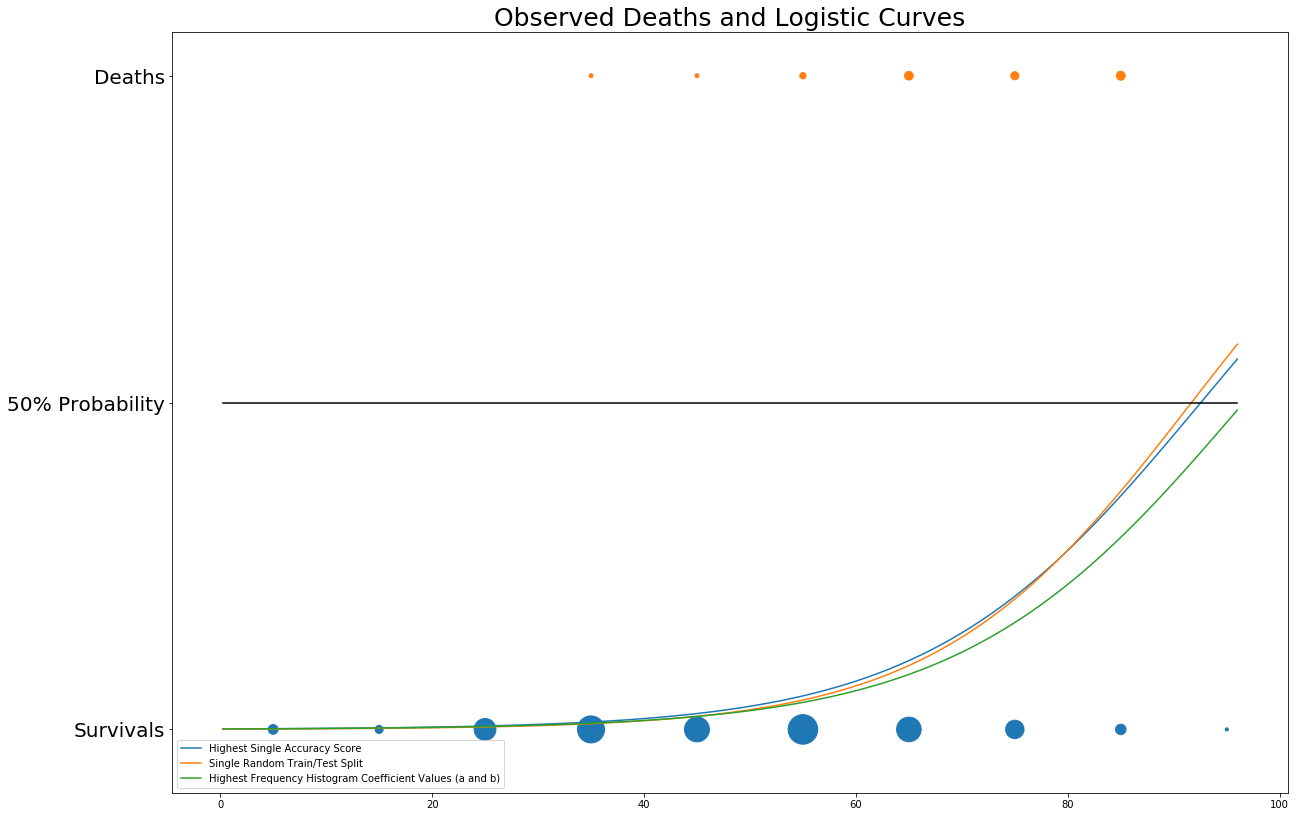

In [189]:
#Plot two logistic curves.
#The first curve is from a single, random train/test split
#The second is using optimized parameters, 
xplot = np.linspace(min(x), max(x), 100)

# Index of prediction with maximum accuracy. Make another plot, this time with this 
# max accuracy prediction.
accMidpoints = (acchist[1][-1:] + ahist[1][1:]) / 2
maxAccIndex = np.argmax(acchist[0])
maxAccA = aparams[maxAccIndex]
maxAccB = bparams[maxAccIndex]


#Get the midpoints of the highest frequency bins, e.g. the "mode"
# of the underlying data
amidpoints = (ahist[1][:-1] + ahist[1][1:]) / 2
bmidpoints = (bhist[1][:-1] + bhist[1][1:]) / 2
amode = amidpoints[np.argmax(ahist[0])]
bmode = bmidpoints[np.argmax(bhist[0])]

plt.plot(xplot, logistic(xplot, maxAccA, maxAccB), 
         label="Highest Single Accuracy Score")
plt.plot(xplot, logistic(xplot, a, b), 
         label="Single Random Train/Test Split")
plt.plot(xplot, logistic(xplot, amode, bmode), 
         label="Highest Frequency Histogram Coefficient Values (a and b)")
plt.scatter(binCenters, [0] * len(binCenters), s= 5 * freqnegatives[0])
plt.scatter(binCenters, [1] * len(binCenters), s= 5 * freqpositives[0])
plt.plot([min(x), max(x)], [1/2] * 2, color="black")

plt.title("Observed Deaths and Logistic Curves", fontsize=25)
plt.legend(loc="best", fontsize=10)
plt.yticks([0, 0.5, 1], ["Survivals", "50% Probability", "Deaths"], fontsize=20)
fig = plt.gcf()
fig.set_size_inches(20,14)

Text(0.5, 1.0, 'ROC For 1 Train/Test Split')

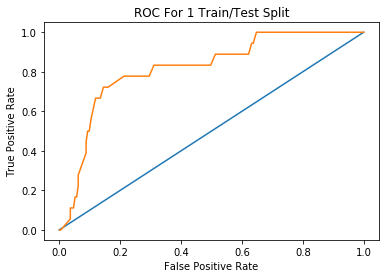

In [190]:
# Roc curve using the optimized a and b values.
from sklearn import metrics
yscores = logistic(xtest, amode, bmode)
fpr, tpr, threshold = metrics.roc_curve(ytest, yscores)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
fig.set_size_inches(20, 20)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC For 1 Train/Test Split")

Text(0.5, 1.0, 'ROC For 10 Train/Test Splits')

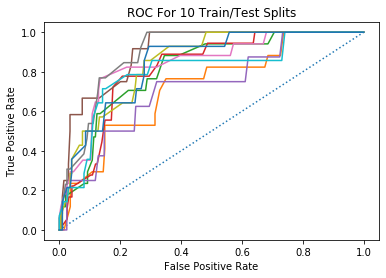

In [193]:
#10 roc curves from 10 train/test splits
accs, aparams, bparams, xtests, ytests = tts_repeat(10, x, y)
plt.plot([0, 1], [0, 1], linestyle="dotted")
#Plot 10 roc curves using the predicted parameters from the above lists.
accs = []
for i in range(10):
    xtrain, xtest, ytrain, ytest = train_test_split(x.reshape(-1,1),y)
    model.fit(xtrain, ytrain)
    probs = model.predict_proba(xtest)[:, 1]
    ypredict = model.predict(xtest)
    fpr, tpr, thresholds = metrics.roc_curve(ytest, probs)
    plt.plot(fpr, tpr)
    accs.append(accuracy_score(ytest, ypredict))
acc10tts = np.mean(accs)
acc10tts
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC For 10 Train/Test Splits")

ValueError: x and y must have same first dimension, but have shapes (1000,) and (10,)

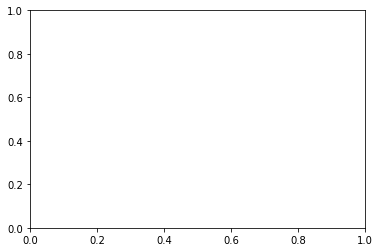

In [192]:
# Compare the accuracy you get with (a) 10 train/ten splits of entire data sets 
# Repeat the train/test split at least ten times 
# to observe the variation in the accuracy. 

#using the values from our previous 1000 train/test splits:
accstd = np.std(accs)
accmean = np.mean(accs)
xspace = np.linspace(1, 1000, 1000)
plt.plot(xspace, accs, linestyle="none", marker=".")
interval95 = (accmean - accstd, accmean + accstd)
plt.plot([min(xspace), max(xspace)], [interval95[1], interval95[1]], color="black")
plt.plot([min(xspace), max(xspace)], [interval95[0], interval95[0]], color="black"),
print("95% confidence interval: " + str(interval95))

In [171]:
#(b) leave out one cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
looScores = cross_val_score(model, x.reshape(-1,1), y, cv=loo, scoring="accuracy")
accloo = np.mean(looScores)

In [174]:
# (c) k-fold splits (use 10 splits)
kScores = cross_val_score(model, x.reshape(-1,1), y, cv=10, scoring="accuracy")
acckfold = np.mean(kScores)
acckfold

0.9276330532212885

In [175]:
#Accuracy yielded by the 3 methods of splitting
print("10 75:25 train test splits: " + str(acc10tts))
print("LOO Cross Validation: " + str(accloo))
print("Cross Validation with 10 splits: " + str(acckfold))

10 75:25 train test splits: 0.9279620853080569
LOO Cross Validation: 0.930011862396204
Cross Validation with 10 splits: 0.9276330532212885
